# Frame Level Speech Recognition with Neural Networks

## Question for the Assesment
In this coursework you will take your knowledge of feedforward neural networks and apply it to the task of speech recognition.

You are provided a dataset of audio recordings (utterances) and their phoneme state (subphoneme) labels. The data comes from articles published in the Wall Street Journal (WSJ) that are read aloud and labelled using the original text. If you have not encountered speech data before or have not heard of phonemes or spectrograms, we will clarify these here:

Phonems and Phoneme States
As letters are the atomic elements of written language, phonemes are the atomic elements of speech. It is crucial for us to have a means to distiguish different sounds in speech that may or may not represent the same letter or combinations of letters in the written alphabet. For example, the words "jet" and "ridge" both contain the same sound and we refer to this elemental sound as the phoneme "JH". For this challenge we will consider 46 phonemes in the english language.

["+BREATH+", "+COUGH+", "+NOISE+", "+SMACK+", "+UH+", "+UM+", "AA", "AE", "AH", "AO", "AW", "AY", "B", "CH", "D", "DH", "EH", "ER", "EY", "F", "G", "HH", "IH", "IY", "JH", "K", "L", "M", "N", "NG", "OW", "OY", "P", "R", "S", "SH", "SIL", "T", "TH", "UH", "UW", "V", "W", "Y", "Z", "ZH"]

A powerful technique in speech recognition is to model speech as a markov process with unobserved states. This model considers observed speech to be dependent on unobserved state transitions. We refer to these unobserved states as phoneme states or subphonemes. For each phoneme, there are 3 respective phoneme states. Therefore for our 46 phonemes, there exist 138 respective phoneme states.

Hidden Markov Models (HMMs) estimate the parameters of this unobserved markov process (transition and emission probabilities) that maximize the likelihood of the observed speech data.

Your task is to instead take a model-free approach and classify mel spectrogram frames using a neural network that takes a frame (plus optional context) and outputs class probabilities for all 138 phoneme states. Performance on the task will be measured by classification accuracy on a held-out set of labelled mel spectrogram frames. Training/dev labels are provided as integers [0-137].

Representing Speech
As a first step, the speech must be converted into a feature representation that can be fed into the network.

In our representation, utterances have been converted to "mel spectrograms", which are pictorial representations that characterize how the frequency content of the signal varies with time. The frequency-domain of the audio signal provides more useful features for distinguishing phonemes.

For a more intuitive understanding, consider attempting to determine which instruments are playing in an orchestra given an audio recording of a performance. By looking only at the amplitude of the signal of the orchestra over time, it is nearly impossible to distinguish one source from another. But if the signal is transformed into the frequency domain, we can use our knowledge that flutes produce higher frequency sounds and bassoons produce lower frequency sounds. In speech, a similar phenomenon is observed when the vocal tract produces sounds at varying frequencies.

To convert the speech to a mel spectrogram, it is segmented into little "frames", each 25ms wide, where the "stride" between adjacent frames is 10ms. Thus we get 100 such frames per second of speech.

From each frame, we compute a single "mel spectral" vector, where the components of the vector represent the (log) energy in the signal in different frequency bands. In the data we have given you, we have 40-dimensional mel-spectral vectors, i.e. we have computed energies in 40 frequency bands.

Thus, we get 100 40-dimensional mel spectral (row) vectors per second of speech in the recording. Each one of these vectors is referred to as a frame. The details of how mel spectrograms are computed from speech is explained in the attached blog.

Thus, for a T-second recording, the entire spectrogram is a 100T x 40 matrix, comprising 100T 40- dimensional vectors (at 100 vectors (frames) per second).

The Training Data Comprises :

Speech Recordings
Frame Level Phoneme State labels
The test data comprises

Speech Recordings
Phoneme state labels are not given
Expected from Us
Your job is to identify the phoneme state label for each frame in the test data set. It is important to note that utterances are of variable length. We are providing you code to load and parse the raw files into the expected format. For now we are only providing dev data files as the training file is very large.

Dataset
Feature File
[train|dev|test].npy contain a numpy object array of shape [utterances]. Each utterance is a float32 ndarray of shape [time, frequency], where time is the length of the utterance. Frequency dimension is always 40 but time dimension is of variable length.

Label Files
[train|dev]_labels.npy contain a numpy object array of shape [utterances]. Each element in the array is an int32 array of shape [time] and provides the phoneme state label for each frame. There are 138 distinct labels [0-137], one for each subphoneme.

You can downlaoad the dataset from here

Implementation
The dataset files are of nearly 8GB size, We can't load them directly to google colab notebook, instead we make use of Google Drive.

Upload the files on Google Drive and make use of Drive feature of the google colaboratry, type the below code, It'll show you a link, Visit that link, give confirmation, copy the auth code and paste it in the dialog box that appears. It will let you access the files in your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading all the Data

Imports 

In [ ]:
import numpy as np

Loading the data

* **train.npy - training features**
* [train|dev|test].npy contain a numpy object array of shape [utterances]. Each utterance is a float32 ndarray of shape [time, frequency], where time is the length of the utterance. Frequency dimension is always 13 but time dimension is of variable length.

In [ ]:
# loading the data file
train_labels = np.load('/content/drive/My Drive/train_labels.npy',allow_pickle=True)  # Allow loading pickled object arrays stored in npy files.
dev_train = np.load('/content/drive/My Drive/dev.npy',allow_pickle=True)              # Reasons for disallowing pickles include security
dev_labels = np.load('/content/drive/My Drive/dev_labels.npy',allow_pickle=True)      # As loading pickled data can execute arbitrary code. 
test =  np.load('/content/drive/My Drive/test.npy',allow_pickle=True)                 # If pickles are disallowed, loading object arrays will fail.

In [ ]:
x = np.concatenate(train)

* **training labels dev.npy - development/validation features**
* [train|dev]_labels.npy contain a numpy object array of shape [utterances]. Each element in the array is an int32 array of shape [time] and provides the phoneme state label for each frame. There are 346 distinct labels [0-345], one for each subphoneme.

In [ ]:
y = np.concatenate(train_labels)

* **dev.npy - development/validation features**
* **dev_labels.npy - development/validation**

**sample.csv - sample submission in correct format**

In [ ]:
import pandas as pd
sample = pd.read_csv('sample/sample.csv')

In [ ]:
y_test = sample['label'].to_numpy()

## Setting up the Model

In [ ]:
!pip install torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
k = 20 # context size for utterance of size (A,13) a k of 5 makes the utterance (A + 2*5, 13)

In [ ]:
class Model(nn.Module):

    def __init__(self,in_features=13*(1 + 2*k),h1=2048,h2=2048,h3=1024*2,h4=1024,h5=900,h6=900,h7=800,
                 h8=800,h9 = 800,h10=800,h11=800,h12=800,h13=800,h14=800,h15=800,out_features=346):
        
        # How many layers?
        # Input layer (# of features) --> hidden layer 1 (number of neurons N) --> h2 (N) --> output (346 of classes)
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.bn1 = nn.BatchNorm1d(num_features=h1,momentum=0.01)
        self.fc2 = nn.Linear(h1,h2)
        self.d2 =  nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(num_features=h2,momentum=0.01)
        self.fc3 = nn.Linear(h2,h3)
        self.bn3 = nn.BatchNorm1d(num_features=h3,momentum=0.01)
        self.d3 = nn.Dropout(0.4)
        self.fc4 = nn.Linear(h3,h4)
        self.bn4 = nn.BatchNorm1d(num_features=h4,momentum=0.01)
        self.d4 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(h4,h5)
        self.bn5 = nn.BatchNorm1d(num_features=h5,momentum=0.01)
        self.d5 = nn.Dropout(0.25)
        self.fc6 = nn.Linear(h5,h6)
        self.bn6 = nn.BatchNorm1d(num_features=h6,momentum=0.01)
        self.d6 = nn.Dropout(0.35)
        
        self.fc7 = nn.Linear(h6,h7)
        self.bn7 = nn.BatchNorm1d(num_features=h7,momentum=0.01)
        self.d7 = nn.Dropout(0.4)
        
        self.fc8 = nn.Linear(h7,h8)
        self.bn8 = nn.BatchNorm1d(num_features=h8,momentum=0.01)
        self.d8 = nn.Dropout(0.35)
        
        self.fc9 = nn.Linear(h8,h9)
        self.bn9 = nn.BatchNorm1d(num_features=h9,momentum=0.01)
        self.d9 = nn.Dropout(0.2)
        
        self.fc10 = nn.Linear(h9,h10)
        self.bn10 = nn.BatchNorm1d(num_features=h10,momentum=0.01)
        self.d10 = nn.Dropout(0.25)
        
        self.fc11 = nn.Linear(h10,h11)
        self.bn11 = nn.BatchNorm1d(num_features=h11,momentum=0.01)
        self.d11 = nn.Dropout(0.2)

        self.fc12 = nn.Linear(h11,h12)
        self.bn12 = nn.BatchNorm1d(num_features=h12,momentum=0.01)
        self.d12 = nn.Dropout(0.2)

        self.fc13 = nn.Linear(h12,h13)
        self.bn13 = nn.BatchNorm1d(num_features=h13,momentum=0.01)
        self.d13 = nn.Dropout(0.2)

        self.fc14 = nn.Linear(h13,h14)
        self.bn14 = nn.BatchNorm1d(num_features=h14,momentum=0.01)
        self.d14 = nn.Dropout(0.2)

        self.fc15 = nn.Linear(h14,h15)
        self.bn15 = nn.BatchNorm1d(num_features=h15,momentum=0.01)
        self.d15 = nn.Dropout(0.2)

        self.out = nn.Linear(h15,out_features)
  
    def forward(self,x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.d2(self.fc2(x))))
        x = F.relu(self.bn3(self.d3(self.fc3(x))))
        x = F.relu(self.bn4(self.d4(self.fc4(x))))
        x = F.relu(self.bn5(self.d5(self.fc5(x))))
        x = F.relu(self.bn6(self.d6(self.fc6(x))))
        x = F.relu(self.bn7(self.d7(self.fc7(x))))
        x = F.relu(self.bn8(self.d8(self.fc8(x))))
        x = F.relu(self.bn9(self.d9(self.fc9(x))))
        x = F.relu(self.bn10(self.d10(self.fc10(x))))
        x = F.relu(self.bn11(self.d11(self.fc11(x))))
        x = F.relu(self.bn12(self.d12(self.fc12(x))))
        x = F.relu(self.bn13(self.d13(self.fc13(x))))
        x = F.relu(self.bn14(self.d14(self.fc14(x))))
        x = F.relu(self.bn15(self.d15(self.fc15(x))))

        x = self.out(x)
        return x

In [ ]:
seq_model = Model()

## Working with Tensors 

In [ ]:
!pip install torchvision

In [ ]:
from __future__ import print_function, division
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
class My_Dataset(Dataset):
    
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        if index > len(self.X) - (k + 1):
            X = torch.Tensor(np.pad(self.X[index-k-1:].float(),pad_width=((0,(k  - len(self.X[index:].float()))),(0,0)),mode='reflect').flatten())
        elif index <  k + 1:
            X = torch.Tensor(np.pad(self.X[:index+k+1].float(),pad_width=((k  - index,0),(0,0)),mode='reflect').flatten())
        else:
            X = self.X[index-k:index+k+1].float().flatten()
            
        Y = self.Y[index].long()
        return X,Y

In [ ]:
X_test = torch.Tensor(np.concatenate(test))
y_test = torch.Tensor(y_test)

In [ ]:
y_val = torch.Tensor(np.concatenate(dev_labels))
x_val = torch.Tensor(np.concatenate(dev_train))

In [ ]:
x = torch.Tensor(x)
y = torch.Tensor(y)

In [ ]:
val_dataset = My_Dataset(x_val,y_val)

In [ ]:
val_loader_args = dict(shuffle=False,batch_size=1024,num_workers=6,pin_memory=True)
val_loader = DataLoader(val_dataset, **val_loader_args)

In [ ]:
test_dataset = My_Dataset(X_test,y_test)

In [ ]:
test_loader_args = dict(shuffle=False,batch_size=1024,num_workers=6,pin_memory=True) 
test_loader = DataLoader(test_dataset, **test_loader_args)

In [ ]:
train_dataset = My_Dataset(x,y)

In [ ]:
train_loader_args = dict(shuffle=True,batch_size=1024,num_workers=6,pin_memory=True,drop_last=True) 
train_loader = DataLoader(train_dataset, **train_loader_args)

# Training the Model

In [ ]:
device = torch.device("cuda")
seq_model.to(device)

Model(
  (fc1): Linear(in_features=585, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=2700, out_features=2700, bias=Tr

In [ ]:
seq_model.train()

Model(
  (fc1): Linear(in_features=585, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=2700, out_features=2700, bias=Tr

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(seq_model.parameters(),lr=1e-4)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=33)

In [ ]:
seq_model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=585, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_featur

In [ ]:
def validation_error(model,criterion,val_loader):
    model.eval()
    loss = []
    for (xii,yii) in val_loader:
        output = model.forward(xii)
        loss = criterion(output,yii.cuda())
    #val_error = np.mean(np.array(loss))
    val_error = loss
    return val_error

In [ ]:
def Testing_Model(seq_model,test_loader,epoch):
  import numpy as np 
  import torch 
  import pandas as pd
  torch.save(seq_model.state_dict(), f'MyModel_{epoch}.pt')
  model2 = Model()
  model2.load_state_dict(torch.load(f'MyModel_{epoch}.pt'));
  device = torch.device("cuda")
  model2.to(device)
  model2.eval()
  test_preds = []
  for (xj,yj) in test_loader:
      output = model2.forward(xj)
      test_preds.append(np.argmax(output.cpu().detach().numpy(),axis=1))
  combined_batches = np.array(test_preds)
  Predictions = np.concatenate(combined_batches)
  id = [i for i in range(len(Predictions))]
  df_pred = pd.DataFrame(data={'id':id,'label':Predictions})
  df_pred.to_csv(f'Predictions.csv',index=False)
  

In [ ]:
%%time
# EPOCHS 
seq_model.train()
epochs = 25
losses = []
loss = []
val_error = []
validation_losses = []
for i in range(epochs):
    losses.append(loss)
    validation_losses.append(val_error)
    seq_model.train()
    print(f'Epoch {i}, loss {loss}, validation loss: {val_error}')
    for (xi,yi) in train_loader:
        optimizer.zero_grad()
        xi = xi.to(device)
        yi = yi.to(device)
        output = seq_model(xi)
        loss = criterion(output,yi)
        loss.backward()
        optimizer.step()

    if (i+1) % 5 == 0:
      Testing_Model(seq_model,test_loader,i)
    val_error = validation_error(seq_model,criterion,val_loader)

In [ ]:
torch.save(seq_model.state_dict(), 'MyModel_V6.pt')

# Predicting on the Test data 

In [ ]:
import numpy as np 
import torch 
import pandas as pd
model2 = Model()
model2.load_state_dict(torch.load(f'MyModel_V11.pt'));
model2.eval()

Model(
  (fc1): Linear(in_features=1001, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=2700, out_features=2700, bias=T

In [ ]:
device = torch.device("cuda")
model2.to(device)

Model(
  (fc1): Linear(in_features=1001, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=2700, out_features=2700, bias=T

In [ ]:
model2.eval()
test_preds = []
print('Hello')
for (xj,yj) in test_loader:
    output = model2.forward(xj)
    test_preds.append(np.argmax(output.cpu().detach().numpy(),axis=1))

Hello


In [ ]:
np.concatenate(np.array(test_preds)).shape

(1593223,)

In [ ]:
combined_batches = np.array(test_preds)
combined_batches.shape

(1556,)

In [ ]:
Predictions = np.concatenate(combined_batches)
Predictions.shape

(1593223,)

In [ ]:
id = [i for i in range(len(Predictions))]

In [ ]:
df_pred = pd.DataFrame(data={'id':id,'label':Predictions})
df_pred

,id,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
1593218,1593218,1
1593219,1593219,1
1593220,1593220,1
1593221,1593221,1


In [ ]:
df_pred.to_csv(f'Predictions.csv',index=False)

# Evaluating Training losses 

In [ ]:
losses = losses[1:]

Text(0, 0.5, 'CrossEntropyLoss')

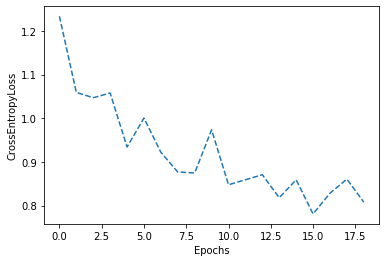

In [ ]:
import seaborn as sns
#sns.set_style('DarkGrid')
plt.plot(losses,'--')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')